In [22]:
import numpy as np
import pandas as pd
import os
import string
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import metrics
import cv2
from sklearn.model_selection import GridSearchCV


dataset = pd.read_csv("leaves_dataset_aug.csv")
dataset.head(5)

X = dataset.iloc[:,2:]

y = dataset['species']
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 135)
X_train.head(5)


#skaliranje
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)


In [24]:
import mahotas as mt
import re
import matplotlib
import matplotlib.pyplot as plt

In [47]:
parameters = [{'kernel': ['rbf'],
               'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5],
               'C': [1, 10, 100, 1000]},
              {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
             ]
svm_clf = GridSearchCV(svm.SVC(decision_function_shape='ovr'), parameters)
svm_clf.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}])

In [48]:
svm_clf.best_params_

{'C': 100, 'kernel': 'linear'}

In [25]:
clf = svm.SVC(C=100.0, decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',)
clf.fit(X_train,y_train)

SVC(C=100.0, gamma=0.01, kernel='linear')

In [26]:
# filename = 'finalized_model2.sav'
# pickle.dump(clf, open(filename, 'wb'))
# pickle.dump(sc_X, open('standard_scaler2.sav', 'wb'))

In [27]:
y_pred = clf.predict(X_test)

metrics.accuracy_score(y_test, y_pred)

0.9928571428571429

In [31]:
def preprocess_leaf(image):
  names = ['area','perimeter','pysiological_length','pysiological_width','aspect_ratio','rectangularity','circularity', \
        'mean_r','mean_g','mean_b','stddev_r','stddev_g','stddev_b', \
        'contrast','correlation','inverse_difference_moments','entropy'
      ]
  df = pd.DataFrame([], columns=names)
    
  gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
  blur = cv2.GaussianBlur(gray, (55,55),0)
  ret,otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  kernel = np.ones((50,50),np.uint8) 
  closing = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, kernel) #mask
  contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  len(contours)

  cnt = contours[0]
  len(cnt)

  area = cv2.contourArea(cnt)
  perimeter = cv2.arcLength(cnt,True)

#species = find_species(file) #prima naziv photografije "file"
#Shape features
  x,y,w,h = cv2.boundingRect(cnt)
  aspect_ratio = float(w)/h
  rectangularity = w*h/area
  circularity = ((perimeter)**2)/area


#Color features
  red_channel = img[:,:,0]
  green_channel = img[:,:,1]
  blue_channel = img[:,:,2]
  blue_channel[blue_channel == 255] = 0
  green_channel[green_channel == 255] = 0
  red_channel[red_channel == 255] = 0

  red_mean = np.mean(red_channel)
  green_mean = np.mean(green_channel)
  blue_mean = np.mean(blue_channel)

  red_std = np.std(red_channel) 
  green_std = np.std(green_channel)
  blue_std = np.std(blue_channel)

#Texture features
  textures = mt.features.haralick(gray)
  ht_mean = textures.mean(axis=0)
  contrast = ht_mean[1]
  correlation = ht_mean[2]
  inverse_diff_moments = ht_mean[4]
  entropy = ht_mean[8]

  vector = [area,perimeter,w,h,aspect_ratio,rectangularity,circularity,\
      red_mean,green_mean,blue_mean,red_std,green_std,blue_std,\
      contrast,correlation,inverse_diff_moments,entropy]
  df_temp = pd.DataFrame([vector],columns=names)
  df = df.append(df_temp)
  return df

In [32]:
train_df = pd.read_csv("train.csv")

In [33]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)


In [34]:
leaf_box = train_df.loc[train_df['image_id'] == "LEAF_0714.jpg"]
print(leaf_box)

           image_id  width  height      x      y      w      h
4057  LEAF_0714.jpg    416     416   76.0    5.0  171.0  247.0
4058  LEAF_0714.jpg    416     416   16.0  229.0  188.0   53.0
4059  LEAF_0714.jpg    416     416  221.0  135.0  187.0  191.0
4060  LEAF_0714.jpg    416     416    9.0  281.0  225.0   98.0


In [35]:
classes = []
def find_class(leaf_features):
  scaled_features = sc_X.transform(leaf_features)
  print(scaled_features)
#  print(scaled_features)
# y_pred_mobile = svm_clf.predict(features_of_img)
  y_pred_mobile = clf.predict(scaled_features)
  classes.append(y_pred_mobile[0])

In [36]:
def find_output(classes):
   return max(set(classes), key = classes.count)

def calculate_percent(classes, class_index):
  result = classes.count(class_index)*100.0/len(classes)
  return result

def get_name(class_index):
  common_names = ['pubescent bamboo','Chinese horse chestnut','Anhui Barberry', \
                'Chinese redbud','true indigo','Japanese maple','Nanmu',' castor aralia', \
                'Chinese cinnamon','goldenrain tree','Big-fruited Holly','Japanese cheesewood', \
                'wintersweet','camphortree','Japan Arrowwood','sweet osmanthus','deodar','ginkgo, maidenhair tree', \
                'Crape myrtle, Crepe myrtle','oleander','yew plum pine','Japanese Flowering Cherry','Glossy Privet',\
                'Chinese Toon','peach','Ford Woodlotus','trident maple','Beales barberry','southern magnolia',\
                'Canadian poplar','Chinese tulip tree','tangerine'
               ]
  return common_names[class_index]

In [37]:
def find_contour(cnts, resized_image):
    contains = []
    y_ri,x_ri, _ = resized_image.shape
    for cc in cnts:
        yn = cv2.pointPolygonTest(cc,(x_ri//2,y_ri//2),False)
        contains.append(yn)

    val = [contains.index(temp) for temp in contains if temp>0]
    print(contains)
    return val[0]

In [38]:
def background_remover(img):
  gs = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
  blur = cv2.GaussianBlur(gs, (55,55),0)
  ret_otsu,im_bw_otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  plt.imshow(im_bw_otsu,cmap='Greys_r')
  kernel = np.ones((50,50),np.uint8)
  closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)
  closing = 255 - closing  # ako su pikeli u intervalu [0,255] ovo je ok, a ako su u intervalu [0.,1.] onda bi bilo 1. - img
  plt.imshow(closing,cmap="Greys_r")
  plt.show()
  contours, hierarchy = cv2.findContours(closing,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  print(len(contours))
  h, w, c = img.shape
  black_img = np.empty([h,w,c],dtype=np.uint8)
  black_img.fill(0)
  plt.imshow(black_img,cmap="Greys_r")
  index = find_contour(contours, img)
  cnt = contours[index]
  mask = cv2.drawContours(black_img, [cnt] , 0, (255,255,255), -1)
  plt.imshow(mask)
  maskedImg = cv2.bitwise_and(img, mask)
  
  white_pix = [255,255,255]
  black_pix = [0,0,0]

  final_img = maskedImg
  h,w,channels = final_img.shape
  for x in range(0,w):
      for y in range(0,h):
          channels_xy = final_img[y,x]
          if all(channels_xy == black_pix):    
              final_img[y,x] = white_pix
  plt.imshow(final_img)
  return final_img

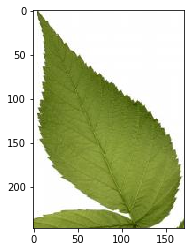

[[-2.46010917e+00 -3.88849715e+00 -3.57550136e+00 -2.85351976e+00
  -1.27201486e+00 -5.54963703e-01  2.20835084e-03  5.02555777e+00
   4.44148275e+00  6.80039348e+00  8.16209532e+00  1.80093618e+00
   6.49047051e+00  1.17641614e+01 -9.95835701e+00 -4.76050820e+00
   4.39646597e+00]]


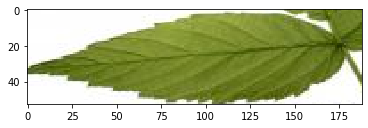

[[ -2.56401893  -4.45722148  -3.50157623  -3.85907788   4.38553909
   -1.61611187   0.08955005   5.02555777   4.44148275   6.80039348
    8.16209532   1.80093618   6.49047051  28.65640468 -26.75904614
   -7.44026598   6.05206575]]


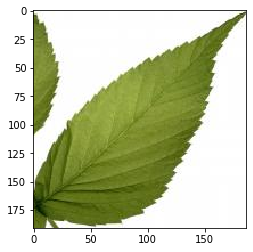

[[ -2.49653044  -3.88563883  -3.50592477  -3.14378396  -0.70375518
   -0.10365658   0.66032082   5.02555777   4.44148275   6.80039348
    8.16209532   1.80093618   6.49047051  13.68445292 -10.4940012
   -4.33433278   4.28379252]]


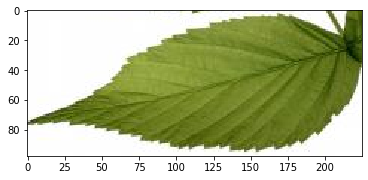

[[ -2.52389924  -4.23049397  -3.34068036  -3.62582987   1.90590181
   -0.97415653  -0.09096401   5.02555777   4.44148275   6.80039348
    8.16209532   1.80093618   6.49047051  19.02230631 -14.70757471
   -5.98938003   5.30577531]]
Found classes:  [11, 11, 11, 11]
This plant is  100.0  percent  Japanese cheesewood


In [39]:
#Identifying plant
# detektovani listovi sa upisanim koordinatama
img = cv2.imread("LEAF_0714.jpg")
classes = []
original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # konvertovanje iz BGR u RGB model boja (OpenCV ucita sliku kao BGR)
for index, row in leaf_box.iterrows():
  crop_img = original_img[int(row['y']):int(row['y'])+int(row['h']), int(row['x']):int(row['x'])+int(row['w'])]
  #crop_img = background_remover(crop_img)
  plt.imshow(crop_img)
  plt.show()
  leaf_features = preprocess_leaf(crop_img)
  find_class(leaf_features)
print("Found classes: ", classes)
leaf_class = find_output(classes)
result = calculate_percent(classes, leaf_class)
print("This plant is ", result, " percent ", get_name(leaf_class))
  #plt.imshow(crop_img)
  #print(row['x'], row['y'], row['w'], row['h'])

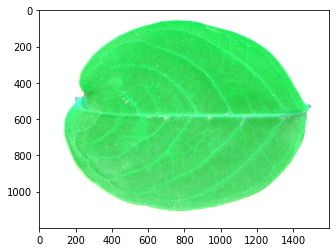

        area    perimeter pysiological_length pysiological_width  \
0  1066397.5  3991.372042                1345               1044   

   aspect_ratio  rectangularity  circularity     mean_r      mean_g  \
0      1.288314        1.316751     14.93913  39.706393  125.098071   

      mean_b   stddev_r    stddev_g   stddev_b  contrast  correlation  \
0  60.542029  40.013291  111.887105  55.305443  3.559969     0.999025   

   inverse_difference_moments   entropy  
0                    0.682749  6.034127  
[18] Crape myrtle, Crepe myrtle


In [40]:
#prepoznavanje lista kada na slici ima jedan list
img = cv2.imread("Leaves/test/2515.jpg")
plt.imshow(img)
plt.show()
original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # konvertovanje iz BGR u RGB model boja (OpenCV ucita sliku kao BGR)
classes = []

leaf_features = preprocess_leaf(original_img)
print(leaf_features)

X_test = sc_X.transform(leaf_features)
y_pred = clf.predict(X_test)
print(y_pred, get_name(y_pred[0]))

In [41]:
breakpoints = [1001,1059,1060,1122,1552,1616,1123,1194,
               1195,1267,1268,1323,1324,1385,1386,1437,
               1497,1551,1438,1496,2001,2050,2051,2113,
               2114,2165,2166,2230,2231,2290,2291,2346,
               2347,2423,2424,2485,2486,2546,2547,2612,
               2616,2675,3001,3055,3056,3110,3111,3175,
               3176,3229,3230,3281,3282,3334,3335,3389,
               3390,3446,3447,3510,3511,3563,3566,3621]

def find_species(file):
    target_num = int(file.split(".")[0])
    flag = 0
    i = 0 
    for i in range(0,len(breakpoints),2):
        if((target_num >= breakpoints[i]) and (target_num <= breakpoints[i+1])):
            flag = 1
            break
    if(flag==1):
        target = int((i/2))
        return target # vraca redni br vrste [0,1...,31]

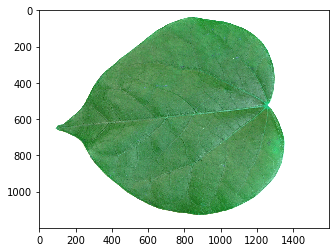

Predicted result:
[3] Chinese redbud
Expected result:
Chinese redbud
Plant is recognized correctly!


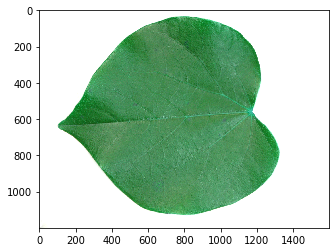

Predicted result:
[3] Chinese redbud
Expected result:
Chinese redbud
Plant is recognized correctly!


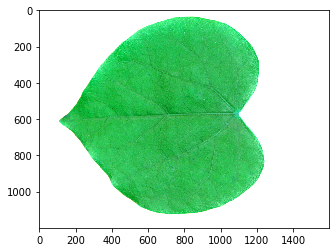

Predicted result:
[3] Chinese redbud
Expected result:
Chinese redbud
Plant is recognized correctly!


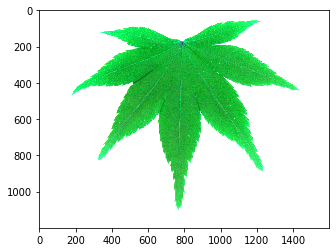

Predicted result:
[5] Japanese maple
Expected result:
Japanese maple
Plant is recognized correctly!


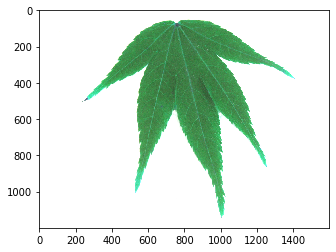

Predicted result:
[5] Japanese maple
Expected result:
Japanese maple
Plant is recognized correctly!


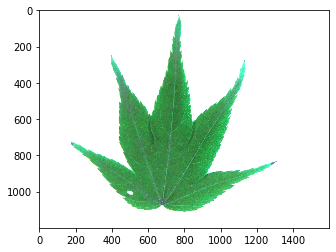

Predicted result:
[5] Japanese maple
Expected result:
Japanese maple
Plant is recognized correctly!


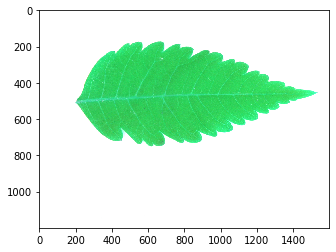

Predicted result:
[9] goldenrain tree
Expected result:
goldenrain tree
Plant is recognized correctly!


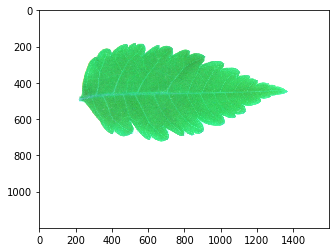

Predicted result:
[9] goldenrain tree
Expected result:
goldenrain tree
Plant is recognized correctly!


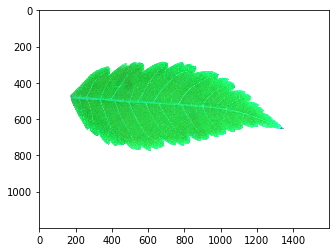

Predicted result:
[9] goldenrain tree
Expected result:
goldenrain tree
Plant is recognized correctly!


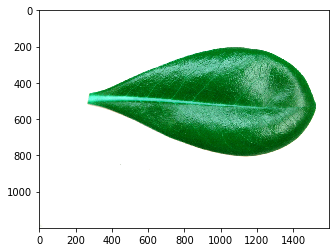

Predicted result:
[11] Japanese cheesewood
Expected result:
Japanese cheesewood
Plant is recognized correctly!


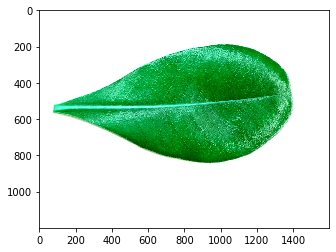

Predicted result:
[11] Japanese cheesewood
Expected result:
Japanese cheesewood
Plant is recognized correctly!


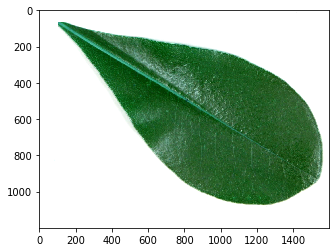

Predicted result:
[11] Japanese cheesewood
Expected result:
Japanese cheesewood
Plant is recognized correctly!


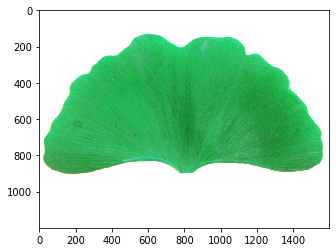

Predicted result:
[3] Chinese redbud
Expected result:
ginkgo, maidenhair tree
Plant is not recognized correctly!


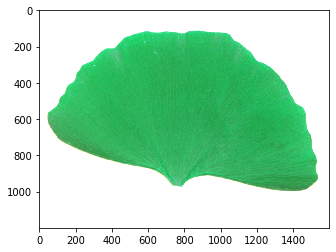

Predicted result:
[3] Chinese redbud
Expected result:
ginkgo, maidenhair tree
Plant is not recognized correctly!


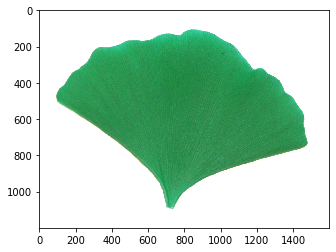

Predicted result:
[3] Chinese redbud
Expected result:
ginkgo, maidenhair tree
Plant is not recognized correctly!


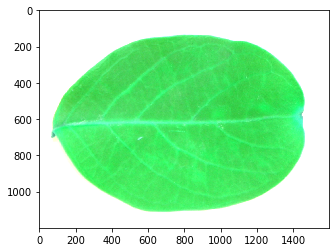

Predicted result:
[18] Crape myrtle, Crepe myrtle
Expected result:
Crape myrtle, Crepe myrtle
Plant is recognized correctly!


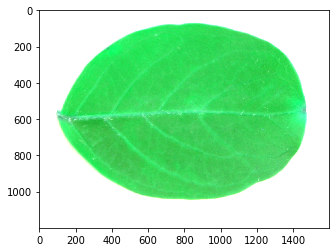

Predicted result:
[18] Crape myrtle, Crepe myrtle
Expected result:
Crape myrtle, Crepe myrtle
Plant is recognized correctly!


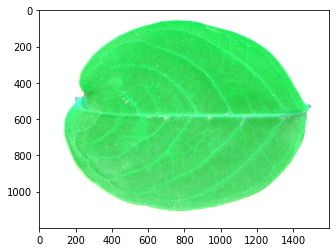

Predicted result:
[18] Crape myrtle, Crepe myrtle
Expected result:
Crape myrtle, Crepe myrtle
Plant is recognized correctly!


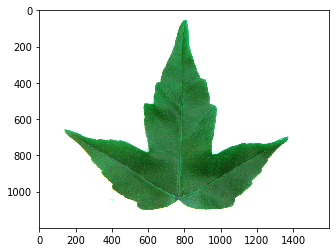

Predicted result:
[26] trident maple
Expected result:
trident maple
Plant is recognized correctly!


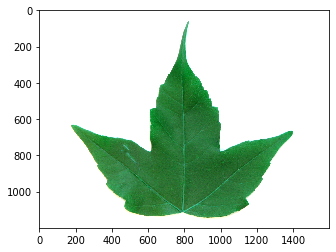

Predicted result:
[26] trident maple
Expected result:
trident maple
Plant is recognized correctly!


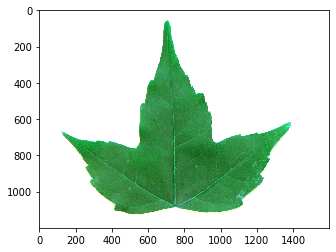

Predicted result:
[26] trident maple
Expected result:
trident maple
Plant is recognized correctly!


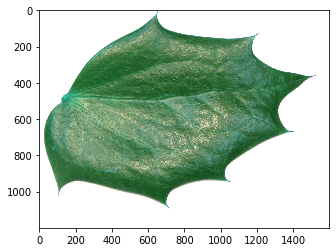

Predicted result:
[27] Beales barberry
Expected result:
Beales barberry
Plant is recognized correctly!


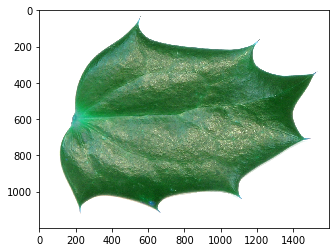

Predicted result:
[27] Beales barberry
Expected result:
Beales barberry
Plant is recognized correctly!


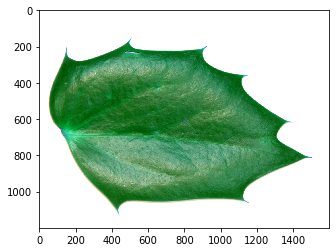

Predicted result:
[27] Beales barberry
Expected result:
Beales barberry
Plant is recognized correctly!


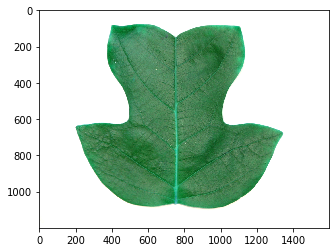

Predicted result:
[26] trident maple
Expected result:
Chinese tulip tree
Plant is not recognized correctly!


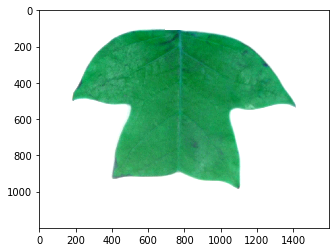

Predicted result:
[26] trident maple
Expected result:
Chinese tulip tree
Plant is not recognized correctly!


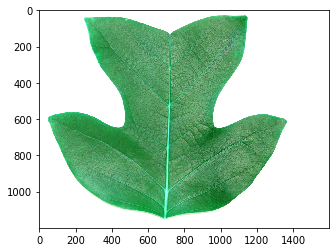

Predicted result:
[26] trident maple
Expected result:
Chinese tulip tree
Plant is not recognized correctly!


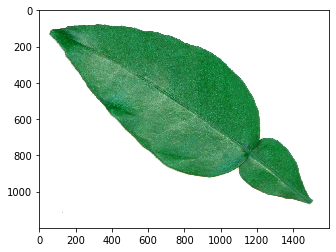

Predicted result:
[11] Japanese cheesewood
Expected result:
tangerine
Plant is not recognized correctly!


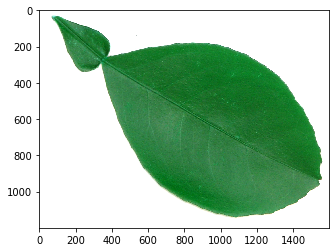

Predicted result:
[31] tangerine
Expected result:
tangerine
Plant is recognized correctly!


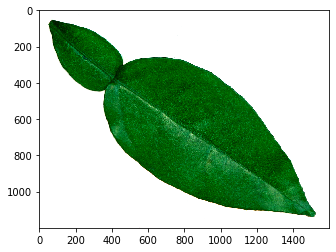

Predicted result:
[31] tangerine
Expected result:
tangerine
Plant is recognized correctly!
Out of 30 pictures, 23 are recognized correctly aka 76.66666666666667 %.


In [42]:
path = "Leaves/test"
files = os.listdir(path)
correct_guesses = 0
images = 0;
for file in files: 
    images = images + 1
    pathPhoto = os.path.join(path,file)
    species = find_species(file)
    img = cv2.imread(pathPhoto)
    plt.imshow(img)
    plt.show()
    original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # konvertovanje iz BGR u RGB model boja (OpenCV ucita sliku kao BGR)

    leaf_features = preprocess_leaf(original_img)

    X_test = sc_X.transform(leaf_features)
    y_pred = clf.predict(X_test)
    print("Predicted result:")
    print(y_pred, get_name(y_pred[0]))
    print("Expected result:")
    print(get_name(species))
    if  get_name(y_pred[0]) == get_name(species):
        correct_guesses = correct_guesses + 1
        print("Plant is recognized correctly!") 
    else:
        print("Plant is not recognized correctly!")

print("Out of", images, "pictures,", correct_guesses, "are recognized correctly aka", correct_guesses/images*100, "%.");
    